先import一些library

In [1]:
import datetime
import os
import time
import warnings
import gc
# import presets
import torch
import torch.utils.data
import torchvision
from tmp_modules import utils,transforms

# from coco_utils import get_coco
from torch import nn
from torch.optim.lr_scheduler import PolynomialLR
from torchvision.transforms import functional as F, InterpolationMode
import torchvision.transforms as transforms
try:
    from pytorch_model_summary import summary
except:
    !pip install pytorch-model-summary
    from pytorch_model_summary import summary

try:
    from torchviz import make_dot
except:
    !pip install torchviz
    from torchviz import make_dot

import transformers
try:
    import datasets
except:
    !pip install cchardet
    !pip install datasets
    import datasets
    
# from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
# from IPython.display import clear_output, display

c:\Users\user\anaconda3\envs\trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


先定義一些function

In [2]:
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = nn.functional.cross_entropy(x, target, ignore_index=255)

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]

def evaluate(model, data_loader, device, num_classes):
    model.eval()
    model.to(device)

    # confmat = utils.ConfusionMatrix(num_classes)
    # metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"
    num_processed_samples = 0
    total_loss            = 0
    with torch.inference_mode():
        for image, target in data_loader: #metric_logger.log_every(data_loader, len(data_loader), header):
            image, target = image.to(device), target.to(device)
            ###
            target = target.squeeze(1)
            # Convert target to Long type
            target = target.type(torch.LongTensor).to(device)
            
            output = model(image)
            loss = criterion(output, target)
            total_loss += loss.item()
            # output = output["out"]
            # confmat.update(target.flatten(), output.argmax(1).flatten())
            # FIXME need to take into account that the datasets
            # could have been padded in distributed setup
            num_processed_samples += image.shape[0]
            
            del image, target, output, loss

            gc.collect()
            torch.cuda.empty_cache()

        # confmat.reduce_from_all_processes()

    # num_processed_samples = utils.reduce_across_processes(num_processed_samples)
    # if (
    #     hasattr(data_loader.dataset, "__len__")
    #     and len(data_loader.dataset) != num_processed_samples
    #     and torch.distributed.get_rank() == 0
    # ):
    #     # See FIXME above
    #     warnings.warn(
    #         f"It looks like the dataset has {len(data_loader.dataset)} samples, but {num_processed_samples} "
    #         "samples were used for the validation, which might bias the results. "
    #         "Try adjusting the batch size and / or the world size. "
    #         "Setting the world size to 1 is always a safe bet."
    #     )

    # return confmat
    return total_loss/ num_processed_samples

def train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, run_device, epoch, pbar, scaler=None):
    cpu_device = torch.device('cpu')
    device     = run_device
    model.train()
    # metric_logger = utils.MetricLogger(delimiter="  ")
    # metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value}"))
    # header = f"Epoch: [{epoch}]"

    error_count   = 0
    training_loss = []
    for idx, (image, target) in enumerate(data_loader): #metric_logger.log_every(data_loader, print_freq, header):
        # print(image.shape,image.dtype,target.shape)
        try:
            image, target = image.to(device), target.to(device)
            with torch.cuda.amp.autocast(enabled=scaler is not None):
                output = model(image)
                loss = criterion(output, target)

            optimizer.zero_grad()
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            
            # 梯度裁減
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            if lr_scheduler is not None:
                lr_scheduler.step()

            pbar.update(idx, values=[("loss",loss.item())])

            # metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"], mem=torch.cuda.memory_allocated(device))
            training_loss.append(loss.item())

            del image, target, output, loss

            gc.collect()
            torch.cuda.empty_cache()
        except:
            error_count += 1
            if error_count < 10:
                model.to(cpu_device)
                gc.collect()
                torch.cuda.empty_cache()
                model.to(device)
                model.train()
            else:
                raise RuntimeError('GPU out of memory error')
    return np.mean(np.array(training_loss))


def train(model, epochs, data_loader, data_loader_valid, early_stop=0, model_pathname=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(torch.cuda.get_device_name(0))
    
    gc.collect()
    torch.cuda.empty_cache()

    model.to(device)
    if hasattr(model,'backbone'):
        params_to_optimize = [
            {"params": [p for p in model.backbone.parameters() if p.requires_grad]},
            {"params": [p for p in model.classifier.parameters() if p.requires_grad]},
        ]
    else:
        params_to_optimize = [{ "params": model.parameters() }]

    optimizer = torch.optim.Adam(params_to_optimize, lr=0.001)
    scaler = None #torch.cuda.amp.GradScaler()
    iters_per_epoch = len(data_loader)
    lr_scheduler    = None # PolynomialLR(optimizer, total_iters=iters_per_epoch * epochs, power=0.9)
    training_loss   = []
    val_loss        = []
    min_val_loss    = np.inf
    min_val_epoch   = 0
    start_time = time.time()

    n_batch = len(data_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch,stateful_metrics=['loss', 'val_loss'])

    for epoch in range(epochs):
        
        print(f'Epoch {epoch+1}/{epochs}')

        tr_loss = train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, epoch, pbar, scaler)

        training_loss.append(tr_loss)

        if data_loader_valid is not None:
            v_loss = evaluate(model, data_loader_valid, device=device, num_classes=1)
            val_loss.append(v_loss)
            pbar.update(n_batch, values=[('loss', tr_loss), ('val_loss', v_loss)])

            # save the parameters with the least loss
            if v_loss < min_val_loss:
                min_val_loss = v_loss
                min_val_epoch= epoch
                if model_pathname is not None:
                    torch.save(model.state_dict(),model_pathname)

            # early stop
            if early_stop > 0 and epoch - min_val_epoch >= early_stop:
                break

        # confmat = evaluate(model, data_loader_valid, device=device, num_classes=num_classes)
        # print(confmat)
        if lr_scheduler is not None:
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
                "epoch": epoch,
            } 
        else:
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
            } 
        # utils.save_on_master(checkpoint, os.path.join('.', f"model_{epoch}.pth"))
        # utils.save_on_master(checkpoint, os.path.join('.', "checkpoint.pth"))

    if data_loader_valid is not None and model_pathname is not None:
        model.load_state_dict(torch.load(model_pathname))

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(f"Training time {total_time_str}")
    return {'loss':training_loss,'val_loss':val_loss}

def showSegmentationResult(model,dataset):
    plt.figure(figsize=(6,6))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for i, idx in enumerate([0, len(dataset)//2, len(dataset)-1]):
        img, target = dataset[idx]
        outputs = model(torch.unsqueeze(img,0).to(device))   
        labels  = torch.squeeze(torch.argmax(outputs['out'].cpu(),dim=1)).numpy()
        plt.subplot(3,3,i*3+1)
        
        plt.imshow(np.transpose(torch.squeeze(img).cpu().numpy(),(1,2,0)))
        plt.axis(False)

        plt.subplot(3,3,i*3+2)
        plt.imshow(target)
        plt.axis(False)

        plt.subplot(3,3,i*3+3)
        plt.imshow(labels)
        plt.axis(False)

    plt.show()
    return

準備資料集

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import os

class SplashDataSet(Dataset):
    def __init__(self, data_dir, train, transform=None):
        # check for training or validation
        if train:
            split = 'training'
        else:
            split = 'validation'
        # get the directory path
        self.data_dir = data_dir
        self.images_dir = os.path.join(data_dir, 'images', split)
        self.annotations_dir = os.path.join(data_dir, 'annotations', split)
        # check the number of image and mask in two directory: images and annotations
        self.images_list = os.listdir(self.images_dir)
        self.annotations_list = os.listdir(self.annotations_dir)
        assert len(self.images_list) == len(self.annotations_list), "Number of images and annotations should be the same."
        
        self.transform = transform
    def __len__(self):
        return len(self.images_list)
    def __getitem__(self, idx):
        # 讀取原圖
        img_name = os.path.join(self.images_dir, self.images_list[idx])
        image = Image.open(img_name)

        # 讀取遮罩
        mask_name = os.path.join(self.annotations_dir, self.annotations_list[idx])
        mask = Image.open(mask_name)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # 因為只有一個類別，將 mask 轉換成二元的 0 和 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        return image, mask

定義Segformer

In [4]:
import torch.nn as nn
from transformers import SegformerForSemanticSegmentation

class SegFormer(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()})
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}        

In [5]:
from transformers import SegformerForSemanticSegmentation
from datasets import load_metric
from torch.utils.data import DataLoader
import tkinter as tk
from tkinter import filedialog

# transform the image
transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

num_classes           = 3
segformer_transform   = transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((128,128),antialias=True)])
segformer_target_transform = transforms.Compose([lambda x:torch.from_numpy(cv2.resize(np.asarray(x),(128,128),cv2.INTER_NEAREST).astype(np.int64)-1)])

# segformer_dataset = torchvision.datasets.OxfordIIITPet("./OxfordIIITPet","trainval",target_types="segmentation",download=True,transform=segformer_transform,target_transform=segformer_target_transform)
# segformer_dataset_val = torchvision.datasets.OxfordIIITPet("./OxfordIIITPet","test",target_types="segmentation",download=True,transform=segformer_transform,target_transform=segformer_target_transform)

data_folder = select_folder()

# create SplashDataSet
dataset = SplashDataSet(data_dir=data_folder, train=True, transform=transform)
dataset_val = SplashDataSet(data_dir=data_folder, train=False, transform=transform)

# use DataLoader to load data in batch_size
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True)
"""
segformer_train_sampler = torch.utils.data.RandomSampler(dataset)
segformer_test_sampler  = torch.utils.data.SequentialSampler(dataset_val)

segformer_data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=8,
        sampler=segformer_train_sampler,
        num_workers=0,
        collate_fn=utils.collate_fn,
        drop_last=True)

segformer_data_loader_valid = torch.utils.data.DataLoader(
       dataset_val, batch_size=1, sampler=segformer_test_sampler, num_workers=0, collate_fn=utils.collate_fn)
"""
segformer_model = SegFormer(num_classes)


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_var', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.weight', 'decode_head.classif

In [6]:
# lc = train(segformer_model,5,segformer_data_loader,segformer_data_loader_valid,model_pathname='segformer.pth')
lc = train(segformer_model,5,dataloader, dataloader_val,model_pathname='segformer.pth')

NVIDIA GeForce RTX 4090
Epoch 1/5


c:\Users\user\anaconda3\envs\trial01\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\user\anaconda3\envs\trial01\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


5/5 [==============================] - 292s 58s/step - loss: nan - val_loss: 1.1089
Epoch 2/5
5/5 [==============================] - 304s 61s/step - loss: nan - val_loss: 1.1089
Epoch 3/5
5/5 [==============================] - 434s 87s/step - loss: nan - val_loss: 1.1089
Epoch 4/5
5/5 [==============================] - 766s 153s/step - loss: nan - val_loss: 1.1089
Epoch 5/5
5/5 [==============================] - 1021s 204s/step - loss: nan - val_loss: 1.1089
Training time 0:17:01


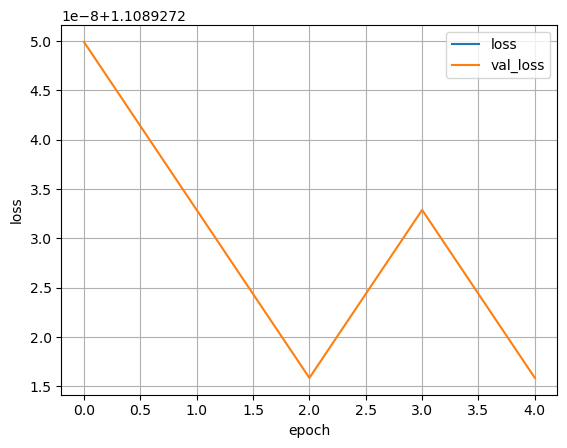

In [7]:
plt.figure()
plt.plot(lc['loss'],label='loss')
plt.plot(lc['val_loss'],label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()